In [13]:
from google.colab import drive
import warnings

drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import glob
import pandas as pd

item_path = os.path.join('drive/MyDrive', 'tfg/data/*')
files = [file for file in glob.glob(item_path) if file.endswith('dataset.csv')]
files_converted = [file for file in glob.glob(item_path) if file.endswith('processed.csv')]
item_name = max(files, key=os.path.getctime)
item_name_converted = max(files_converted, key=os.path.getctime)

data = pd.read_csv(item_name)
data_converted = pd.read_csv(item_name_converted)
data_converted.head()

log_duration  log_minhr  log_maxhr  log_avghr  log_trainingeffect  \
0         13802        100        122        118                 1.8   
1         11346        108        122        119                 2.0   
2         11367         53        161         95                 3.6   
3         15777         98        117        116                 1.8   
4          7986         71        132         96                 2.2   

   log_totenergyconsumption  log_hrabovetime  log_maxventilation  \
0                       236             8504                  15   
1                       171             5656                  22   
2                       293            10616                  56   
3                       306            11592                  14   
4                       242             7986                  29   

   log_maxoxygenconsumption  log_maxbreathingfrequency  ...  next_cancer_mama  \
0                         6                         17  ...                 1   
1                         7                         26  ...                 1   
2                        20                         28  ...                 1   
3                         6                         15  ...                 1   
4                        13                         30  ...                 1   

   next_cancer_laringe  next_cancer_prostata  next_cancer_pancreas  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   next_cancer_utero  next_cancer_vejiga  next_cancer_gastrico  \
0                  0                   0                     0   
1                  0                   0                     0   
2                  0                   0                     0   
3                  0                   0                     0   
4                  0                   0                     0   

   next_cancer_linfoma  next_cancer_colon  next_cancer_tiroides  
0                    0                  0                     0  
1                    0                  0                     0  
2                    0                  0                     0  
3                    0                  0                     0  
4                    0                  0                     0  

[5 rows x 219 columns]

In [15]:
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import joblib
import itertools
import statistics
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

def load_results(X_test, X_test_norm, y_test, model, target, kernel, ard, previous, index):
    epoch_path = os.path.join('drive/MyDrive', 'tfg/epoch')
    suffix = list()
    if kernel:
        suffix.append(kernel)
    if ard:
        suffix.append('ard')
    if previous:
        suffix.append('previous')
    suffix = f'-{"-".join(suffix)}' if suffix else ''
    epoch_name = os.path.join(epoch_path, f'{index}-{model}-{target[5:]}{suffix}.joblib')
    with open(epoch_name, mode='rb') as file:
        best_estimator = joblib.load(file)
    if model.startswith('gaussian-process'):
        y_pred = best_estimator.predict(X_test_norm, full_cov=True)[0]
    else:
        y_pred = best_estimator.predict(X_test)
    if target.endswith('vo2pico'):
        y_pred[y_pred < 3.5] = 3.5
        y_pred[y_pred > 75] = 75
    elif target.endswith('wattpico'):
        y_pred[y_pred < 5] = 5
        y_pred[y_pred > 400] = 400        
    elif target.endswith('fcuvp') or target.endswith('fcucrp'):
        y_pred[y_pred < 30] = 30
        y_pred[y_pred > 220] = 220 

    mae = round(median_absolute_error(y_test, y_pred), 4)
    mse = round(mean_squared_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    return best_estimator, epoch_name, y_pred, mae, mse, r2

def choose_parameter(parameter_range, selected_parameters, parameter_combinations):
    if len(parameter_range) == len(selected_parameters):
        parameter_combinations.append(selected_parameters)
        return

    last_selected_parameter = max(selected_parameters) if len(selected_parameters) != 0 else '0'
    for parameter, value_range in parameter_range.items():
        if (parameter not in selected_parameters and parameter > last_selected_parameter):
            for value in value_range:
                newly_selected_parameters = {parameter: value}
                newly_selected_parameters.update(selected_parameters)
                choose_parameter(parameter_range, newly_selected_parameters, parameter_combinations)

def find_parameter_combinations(parameter_range):
    parameter_combinations = list()
    choose_parameter(parameter_range, dict(), parameter_combinations)
    return parameter_combinations 

def compute_feature_importances(feature_importances, best_estimator, epoch_name, X_train_norm, model, ard, index):
    if model in {'kernel-ridge-linear', 'kernel-ridge-rbf'}:
        feature_importances[index, :, 0] = np.abs(X_train_norm.T @ best_estimator['model'].dual_coef_).to_numpy().reshape(-1)
    elif model in {'lasso', 'elastic-net', 'ard'}:
        feature_importances[index, :, 0] = np.abs(best_estimator['model'].coef_)
    elif model.startswith('random-forest'):
        feature_importances[index, :, 0] = best_estimator['model'].feature_importances_
    elif model.startswith('gaussian-process') and ard:
        kernel = best_estimator.kern
        for order, kern in enumerate(epoch_name[:-7].split('-')[4:]):
            if kern == 'linear':
                feature_importances[index, :, order] = kernel.linear.variances.values 
            elif kern == 'rbf':
                feature_importances[index, :, order] = kernel.rbf.lengthscale.values
            elif kern == 'matern32':
                feature_importances[index, :, order] = kernel.Mat32.lengthscale.values
            elif kern == 'matern52':
                feature_importances[index, :, order] = kernel.Mat52.lengthscale.values
    
def score_model_parameters(data, model, target, kernel=None, ard=False, previous=False, cv=10):    
    excluded = [field for field in data.columns if field.startswith('next')]
    if not previous:
        excluded += [field for field in data.columns if field.startswith('previous') and field not in {'previous_edad', 'previous_peso', 'previous_talla', 'previous_imc', 'previous_fco'} and not field.startswith('previous_cancer')]
    target = f'next_{target}'
    y = data[[target]]
    X = data.drop(excluded, axis=1)
    non_binary_fields = [field for field in X.columns if field not in {'log_personal_smoking', 'user_gender'} and not field.startswith('previous_cancer') and not field.startswith('next_cancer')]
    binary_fields = [field for field in X.columns if field not in non_binary_fields]
    fields = non_binary_fields + binary_fields

    rows, columns = X.shape
    folds = KFold(n_splits=cv, shuffle=True, random_state=42)
    mae_total = mse_total = r2_total = 0
    predictions = list()
    feature_importances = np.zeros((cv, columns, 2))
    for index, (train_index, test_index) in enumerate(folds.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if model.startswith('kernel') or model.startswith('gaussian-process'):
            scaler = StandardScaler().fit(X_train[non_binary_fields])
            X_train_norm = pd.DataFrame(np.concatenate((scaler.transform(X_train[non_binary_fields]), X_train[binary_fields]), axis=1), columns=fields)
            X_test_norm = np.concatenate((scaler.transform(X_test[non_binary_fields]), X_test[binary_fields]), axis=1)
        else:
            X_train_norm = X_test_norm = None

        best_estimator, epoch_name, y_pred, mae, mse, r2 = load_results(X_test, X_test_norm, y_test, model, target, kernel, ard, previous, index)
        mae_total += mae
        mse_total += mse
        r2_total += r2
        predicted_name, true_name = f'{target[5:].capitalize()} (predicted)', f'{target[5:].capitalize()} (true)'
        predictions.append(pd.DataFrame({predicted_name: y_pred.squeeze(), true_name: y_test.squeeze()}, index=test_index))
        compute_feature_importances(feature_importances, best_estimator, epoch_name, X_train_norm, model, ard, index)
    predictions = pd.concat(predictions).sort_values(by=true_name)
    feature_importances = pd.DataFrame(feature_importances[:, :, 0], columns=fields)
    feature_importances = feature_importances.reindex(feature_importances.median().sort_values(ascending=False).index, axis=1)
    return  mae_total/cv, mse_total/cv, r2_total/cv, predictions, feature_importances

def score_model(data, model_parameters, user_index, feature_limit=50, user_limit=10):
    print(f'Regression results for {model_parameters["target"][0]} ({model_parameters["cv"][0]} cross-validation folds)')
    models = model_parameters['model']
    preceding = model_parameters['previous']
    figure, axes = plt.subplots(len(preceding), len(models)+3, figsize=(90, 20))
    spacer, __ = plt.subplots()
    spacer.set_visible(False)
    spacer.set_figheight(.5)
    figure_, axes_ = plt.subplots(len(preceding), len(models)+3, figsize=(90, 20))
    figure.suptitle('Predicted values against true values when previous ergospirometry data is excluded (up) and included (down)', fontsize=30)
    figure_.suptitle(f'Feature importance scores ({feature_limit} feature limit) when previous ergospirometry data is excluded (up) and included (down)', fontsize=30)
    print(f'Models scored: {", ".join([model.replace("-", " ").replace("rbf", "RBF").replace("ard", "ARD") for model in models])}')
    results = pd.DataFrame()
    importances = dict()
    min_mae = min_mse = float('inf')
    max_r2 = 0
    mae_candidate = mse_candidate = r2_candidate = None
    for previous in preceding:
        if previous:
            print('Previous ergospirometry data included')
        else:
            print('Previous ergospirometry data excluded')
        model_parameters['previous'] = [previous]
        print('Stand-alone models')
        print('Model'.ljust(20), 'MAE'.ljust(10), 'MSE'.ljust(10), 'R2'.ljust(10))
        for index, model in enumerate(models):
            model_parameters['model'] = [model]
            if model == 'gaussian-process':
                model_parameters['kernel'] = ['linear', 'rbf', 'matern32', 'matern52', 'linear-rbf', 'linear-matern32', 'linear-matern52']
                model_parameters['ard'] = [False, True]
            for parameter_combination in find_parameter_combinations(model_parameters):
                mae_total, mse_total, r2_total, predictions, feature_importances = score_model_parameters(data, **parameter_combination)
                if mae_total < min_mae:
                    min_mae = mae_total
                    mae_candidate = model
                if mse_total < min_mse:
                    min_mse = mse_total
                    mse_candidate = model
                if r2_total > max_r2:
                    max_r2 = r2_total
                    r2_candidate = model
                results[model] = predictions.iloc[:, 0]
                importances[model] = feature_importances
                model_name = model.replace('-', ' ').replace('rbf', 'RBF').replace('ard', 'ARD')
                print(model_name.ljust(20), str(round(mae_total, 4)).ljust(10), str(round(mse_total, 4)).ljust(10), str(round(r2_total, 4)).ljust(10))#, feature_importances)

            row = int(previous)
            axis = axes[row][index]
            indices = range(predictions.shape[0])
            if not previous:
                header = model_name[0].upper() + model_name[1:]
            else:
                header = ''
            axis.set_title(header, fontdict={'fontsize': 25})
            axis.plot(indices, predictions.iloc[:, 1], color='r')
            axis.scatter(indices, predictions.iloc[:, 0], marker='.', color='#1b7ced')
            if target.endswith('vo2pico'):
                axis.set_ylim(bottom=5)
                axis.set_ylim(top=50)
            elif target.endswith('wattpico'):
                axis.set_ylim(bottom=0)
                axis.set_ylim(top=300)    
            elif target.endswith('fcuvp'):
                axis.set_ylim(bottom=40)
                axis.set_ylim(top=90)              
            axis_ = axes_[row][index]
            axis_.set_title(header, fontdict={'fontsize': 25})
            feature_importances.boxplot(column=list(feature_importances.columns)[:feature_limit], ax=axis_, rot=90, color=dict(boxes='#1b7ced', whiskers='#1b7ced', medians='r', caps='k'))
        results['y_test'] = predictions.iloc[:, 1]
        print()
        
        print('Ensemble models')
        print(' '*80, 'Aggregated by mean'.ljust(32), 'Aggregated by median')
        print('Ensemble'.ljust(80), 'MAE'.ljust(10), 'MSE'.ljust(10), 'R2'.ljust(10), 'MAE'.ljust(10), 'MSE'.ljust(10), 'R2'.ljust(10))
        y_test = results['y_test']
        for index in range(2, len(models)):
            for combination in itertools.combinations(models, index):
                combination = list(combination)
                ensemble = ' + '.join(combination)#[model.replace('-', ' ') for model in ensemble])
                ensemble_mean, ensemble_median = ensemble + ' (mean)', ensemble + ' (median)'
                y_pred_mean = results[combination].mean(axis=1)
                results[ensemble_mean] = y_pred_mean
                mae_mean = round(median_absolute_error(y_test, y_pred_mean), 4)
                mse_mean = round(mean_squared_error(y_test, y_pred_mean), 4)
                r2_mean = round(r2_score(y_test, y_pred_mean), 4)
                if mae_mean < min_mae:
                    min_mae = mae_mean
                    mae_candidate = ensemble_mean 
                if mse_mean < min_mse:
                    min_mse = mse_mean
                    mse_candidate = ensemble_mean
                if r2_mean > max_r2:
                    max_r2 = r2_mean
                    r2_candidate = ensemble_mean
                y_pred_median = results[combination].median(axis=1)
                results[ensemble_median] = y_pred_median
                mae_median = round(median_absolute_error(y_test, y_pred_mean), 4)
                mse_median = round(mean_squared_error(y_test, y_pred_mean), 4)
                r2_median = round(r2_score(y_test, y_pred_mean), 4)
                if mae_median < min_mae:
                    min_mae = mae_median
                    mae_candidate = ensemble_median
                if mse_median < min_mse:
                    min_mse = mse_median
                    mse_candidate = ensemble_median
                if r2_median > max_r2:
                    max_r2 = r2_median
                    r2_candidate = ensemble_median
                print(ensemble.replace('-', ' ').replace('rbf', 'RBF').replace('ard', 'ARD').ljust(80), str(mae_mean).ljust(10), str(mse_mean).ljust(10), str(r2_mean).ljust(10), str(mae_median).ljust(10), str(mse_median).ljust(10), str(r2_median).ljust(10))
        print()

        print('Optimal validation models')
        print(f'Lowest MAE: {mae_candidate.replace("-", " ").replace("rbf", "RBF").replace("ard", "ARD")}')
        print(f'Lowest MSE: {mse_candidate.replace("-", " ").replace("rbf", "RBF").replace("ard", "ARD")}')
        print(f'Highest R2: {r2_candidate.replace("-", " ").replace("rbf", "RBF").replace("ard", "ARD")}')
        for index, (header, candidate) in enumerate([('Highest R2', r2_candidate), ('Lowest MSE', mse_candidate), ('Lowest MAE', mae_candidate)]):
            if '+' in candidate:
                candidates = candidate.replace(' (mean)', '').replace(' (median)', '').split(' + ')
            else:
                candidates = [candidate]
            predictions_ = results[candidate]
            axis = axes[row][-(index+1)]
            indices = range(predictions_.shape[0])
            if not previous:
                axis.set_title(f'{header}: {candidate.replace("-", " ").replace("rbf", "RBF").replace("ard", "ARD")}', fontdict={'fontsize': 25})
            axis.plot(indices, results['y_test'], color='r')
            axis.scatter(indices, predictions_, marker='.', color='c')
            if target.endswith('vo2pico'):
                axis.set_ylim(bottom=5)
                axis.set_ylim(top=50)
            elif target.endswith('wattpico'):
                axis.set_ylim(bottom=0)
                axis.set_ylim(top=300) 
            elif target.endswith('fcuvp'):
                axis.set_ylim(bottom=40)
                axis.set_ylim(top=90) 
            columns = importances[candidates[0]].columns
            median_total = pd.Series([0]*len(columns), index=columns)
            index_total = pd.Series([0]*len(columns), index=columns)
            for i, item in enumerate(candidates):
                median = importances[item].median()
                median_total += (median - median.mean()) / median.std()
                index_total += 1 / (1 + pd.Series(range(len(median.index)), index=median.index))
            median_total /= len(candidates)
            index_total /= len(candidates)
            median_total = (median_total - median_total.min()) / (median_total.max() - median_total.min())
            index_total = (index_total - index_total.min()) / (index_total.max() - index_total.min())
            #if len(candidates) > 1:
            #    print(index_total)
            axis_ = axes_[row][-(index+1)]
            if not previous:
                axis_.set_title(f'{header}: {candidate.replace("-", " ").replace("rbf", "RBF").replace("ard", "ARD")}', fontdict={'fontsize': 25})
            ranking = pd.DataFrame({'Median importance scores': median_total, 'Median importance ranking': index_total})
            ranking = ranking.sort_values(by='Median importance scores', ascending=False)
            ranking = ranking.iloc[:feature_limit]
            ranking.plot.bar(ax=axis_, color=['c', 'r'])
        print()

    columns = results.columns
    for column in columns:
        error = results[column] - results['y_test']
        results[f'AE {column}'] = error.abs()
        results[f'SE {column}'] = error ** 2
    ae_results = results[[column for column in results if column.startswith('AE')]]
    ae_results_mean = ae_results.mean(axis=1)
    ae_results_median = ae_results.median(axis=1)    
    se_results = results[[column for column in results if column.startswith('SE')]]
    se_results_mean = se_results.mean(axis=1)
    se_results_median = se_results.median(axis=1)
    user_error = dict()
    for index, user_id in user_index.items():
        ae_mean = ae_results_mean.loc[index]
        ae_median = ae_results_median.loc[index]
        se_mean = se_results_mean.loc[index]
        se_median = se_results_median.loc[index]
        if user_id not in user_error:
            user_error[user_id] = {'ae_mean': [ae_mean], 'ae_median': [ae_median], 'se_mean': [se_mean], 'se_median': [se_median]}
        else:
            result = user_error[user_id]
            result['ae_mean'].append(ae_mean)
            result['ae_median'].append(ae_median)
            result['se_mean'].append(se_mean)
            result['se_median'].append(se_median)
    users = list(user_error.keys())
    outliers = pd.DataFrame(index=users)
    for user in user_error:
        result = user_error[user]
        for statistic in result:
            result[statistic] = (statistics.mean(result[statistic]), statistics.median(result[statistic]))
    for index, aggregator in enumerate(['mean', 'median']):
        for statistic in ['ae_mean', 'ae_median', 'se_mean', 'se_median']:
           outliers[f'{aggregator}_{statistic}'] = [user_error[user_id][statistic][index] for user_id in users]
    #print(outliers)

    print(f'Outlier analysis on patients')
    user_count = dict()
    user_ranking = dict()
    for statistic in ['mean', 'median']:
        print(f'Error aggregated by {statistic} across models')
        #columns = [column for column in outliers if column.endswith(statistic)]
        for error in ['ae', 'se']:
            if error == 'ae':
                print('Absolute error (descending)')
            else:
                print('Squared error (descending)')
            print('Aggregated by mean'.ljust(31), 'Aggregated by median')
            print('Patient'.ljust(15), 'Error'.ljust(15), 'Patient'.ljust(15), 'Error')
            mean_error = list(outliers[f'mean_{error}_{statistic}'].sort_values(ascending=False).items())
            median_error = list(outliers[ f'median_{error}_{statistic}'].sort_values(ascending=False).items())
            for index in range(min(user_limit, len(mean_error))):
                patient_mean = mean_error[index][0]
                patient_median = median_error[index][0]
                print(str(patient_mean).ljust(15), str(round(mean_error[index][1], 4)).ljust(15), str(patient_median).ljust(15), str(round(median_error[index][1], 4)))
                user_count[patient_mean] = user_count.get(patient_mean, 0) + 1
                try:
                    user_ranking[patient_mean].append(index + 1)
                except:
                    user_ranking[patient_mean] = [index + 1]
                user_count[patient_median] = user_count.get(patient_median, 0) + 1
                try:
                    user_ranking[patient_median].append(index + 1)
                except:
                    user_ranking[patient_median] = [index + 1]
            #print(mean_error)
            #print(median_error)
            print()
    print(f'Outlier patterns for patients ({min(user_limit, len(mean_error))} patient limit)')
    print('Patient'.ljust(15), 'Appearances'.ljust(15))
    print(' '*31, 'Ranking')
    print(' '*31, 'Mean'.ljust(10), 'Median'.ljust(10), 'Mode')
    for patient in sorted(user_count, key=lambda user: (user_count[user], 1/statistics.mean(user_ranking[user])))[::-1]:
        mean_ranking = round(statistics.mean(user_ranking[patient]), 4)
        if mean_ranking == int(mean_ranking):
            mean_ranking = int(mean_ranking)
        median_ranking = statistics.median(user_ranking[patient])
        if median_ranking == int(median_ranking):
            median_ranking = int(median_ranking)
        mode_ranking = ', '.join([str(mode) for mode in stats.mode(user_ranking[patient])[0].tolist()])
        print(str(patient).ljust(15), f'{user_count[patient]}/8'.ljust(15), str(mean_ranking).ljust(10), str(median_ranking).ljust(10), mode_ranking)
    print('\n')

Regression results for vo2pico (10 cross-validation folds)
Models scored: lasso, kernel ridge linear, kernel ridge RBF, elastic net, ARD, random forest
Previous ergospirometry data excluded
Stand-alone models
Model                MAE        MSE        R2        
lasso                2.1212     9.1702     0.7809    
kernel ridge linear  2.5977     13.461     0.6772    
kernel ridge RBF     0.6831     7.7828     0.8142    
elastic net          2.2713     9.8715     0.7647    
ARD                  2.0036     8.919      0.7871    
random forest        2.9321     18.3954    0.5609    

Ensemble models
                                                                                 Aggregated by mean               Aggregated by median
Ensemble                                                                         MAE        MSE        R2         MAE        MSE        R2        
lasso + kernel ridge linear                                                      2.3182     10.1479    0.7612     

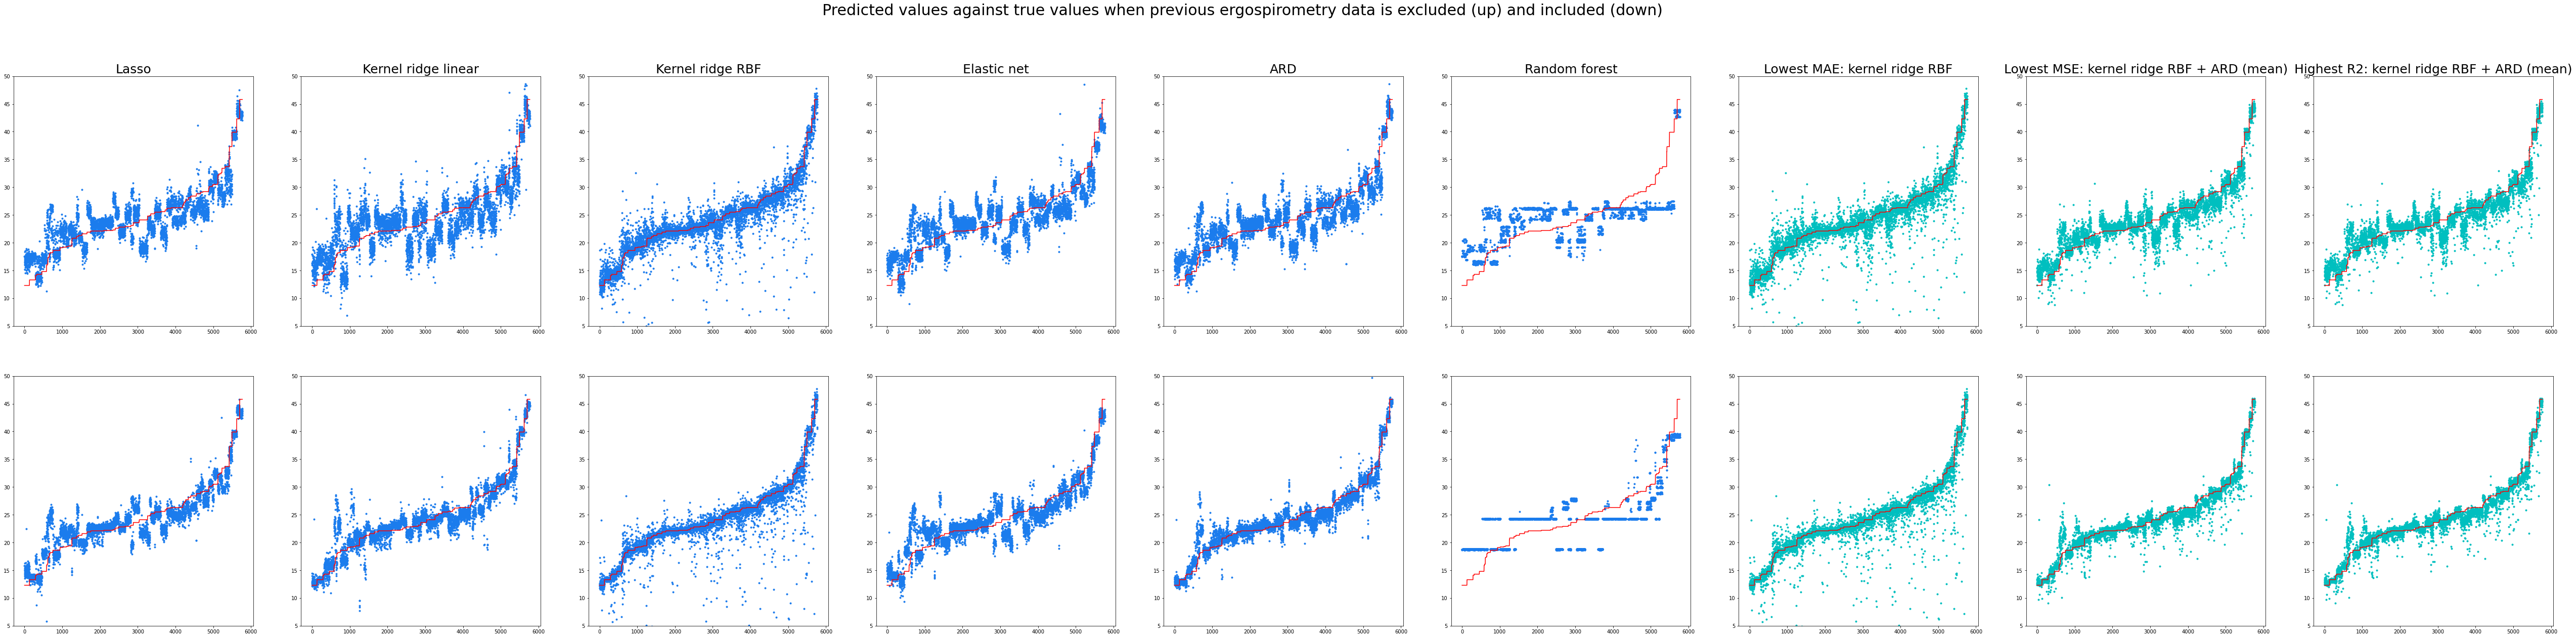

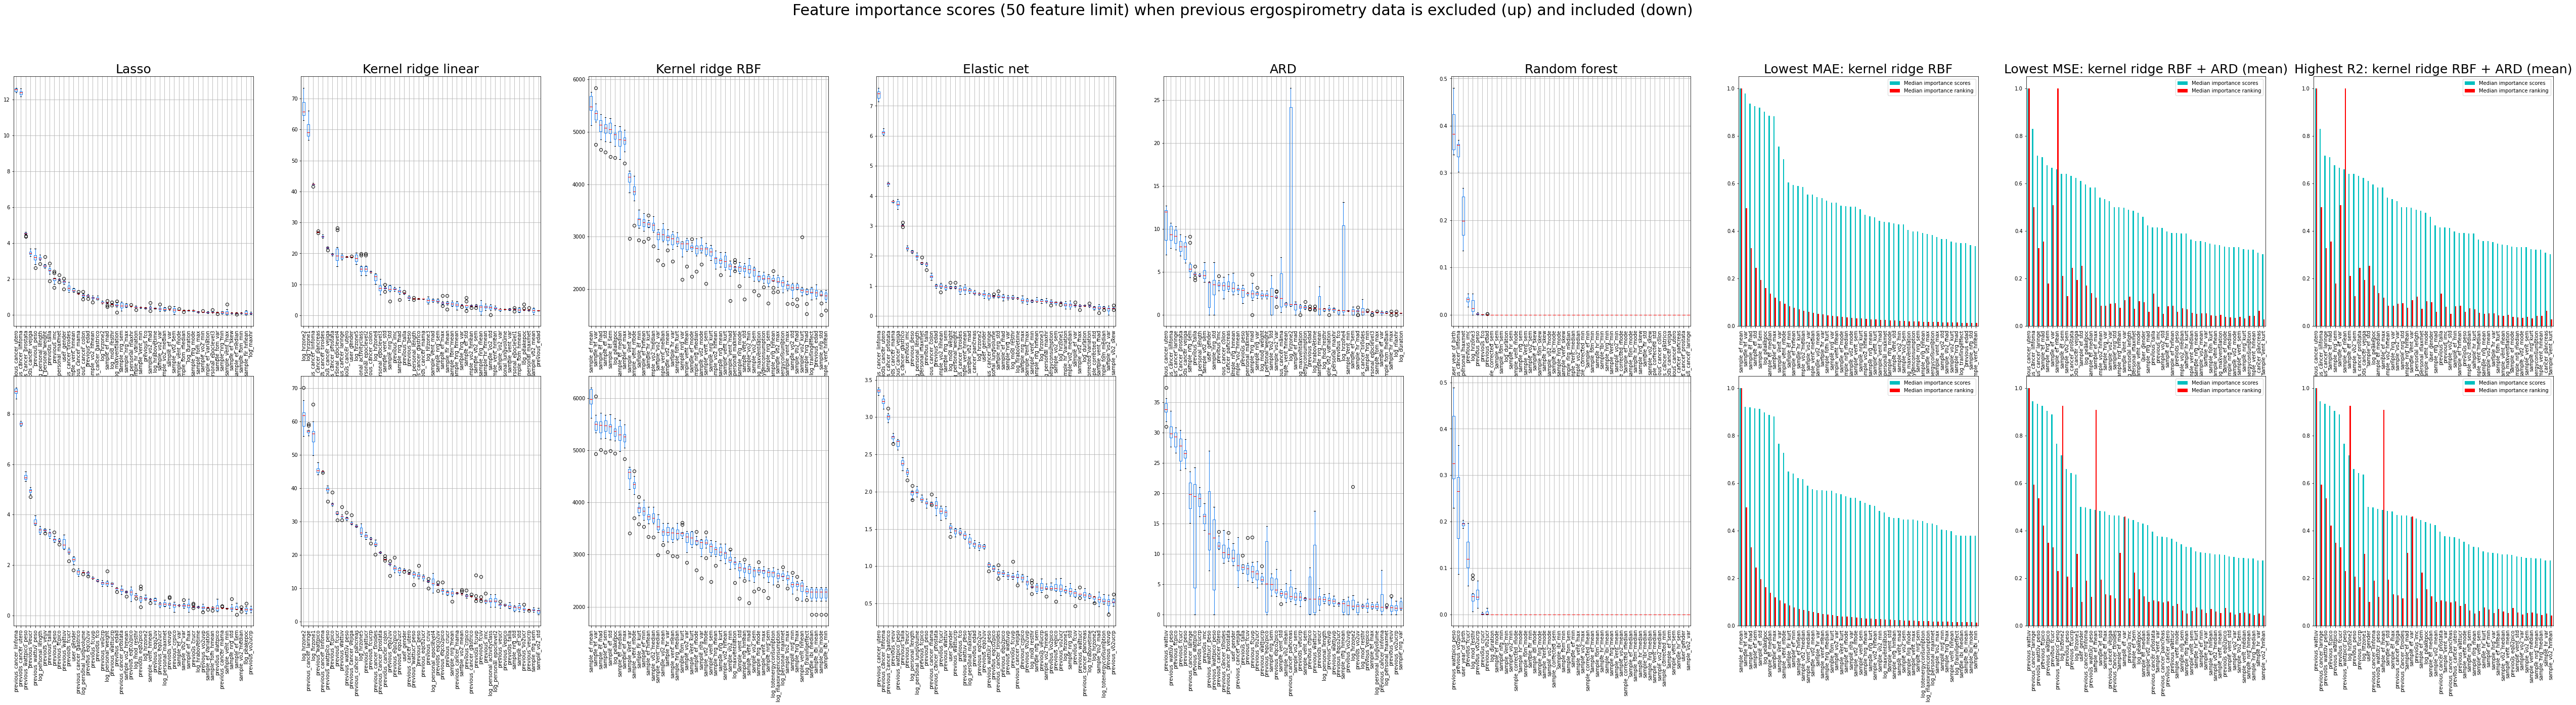

In [22]:
models = ['lasso', 'kernel-ridge-linear', 'kernel-ridge-rbf', 'elastic-net', 'ard', 'random-forest']
target = 'vo2pico'
model_parameters = {'model': models, 'target': [target], 'previous': [False, True], 'cv': [10]}
user_index = data['user_id'].to_dict()
score_model(data_converted, model_parameters, user_index)

Regression results for wattpico (10 cross-validation folds)
Models scored: lasso, kernel ridge linear, kernel ridge RBF, elastic net, ARD, random forest
Previous ergospirometry data excluded
Stand-alone models
Model                MAE        MSE        R2        
lasso                8.7804     186.272    0.9254    
kernel ridge linear  12.193     318.6394   0.8714    
kernel ridge RBF     2.8555     220.2599   0.9122    
elastic net          8.8853     203.1655   0.9186    
ARD                  8.7323     182.6435   0.927     
random forest        17.7045    463.0286   0.8146    

Ensemble models
                                                                                 Aggregated by mean               Aggregated by median
Ensemble                                                                         MAE        MSE        R2         MAE        MSE        R2        
lasso + kernel ridge linear                                                      10.411     214.0389   0.9146    

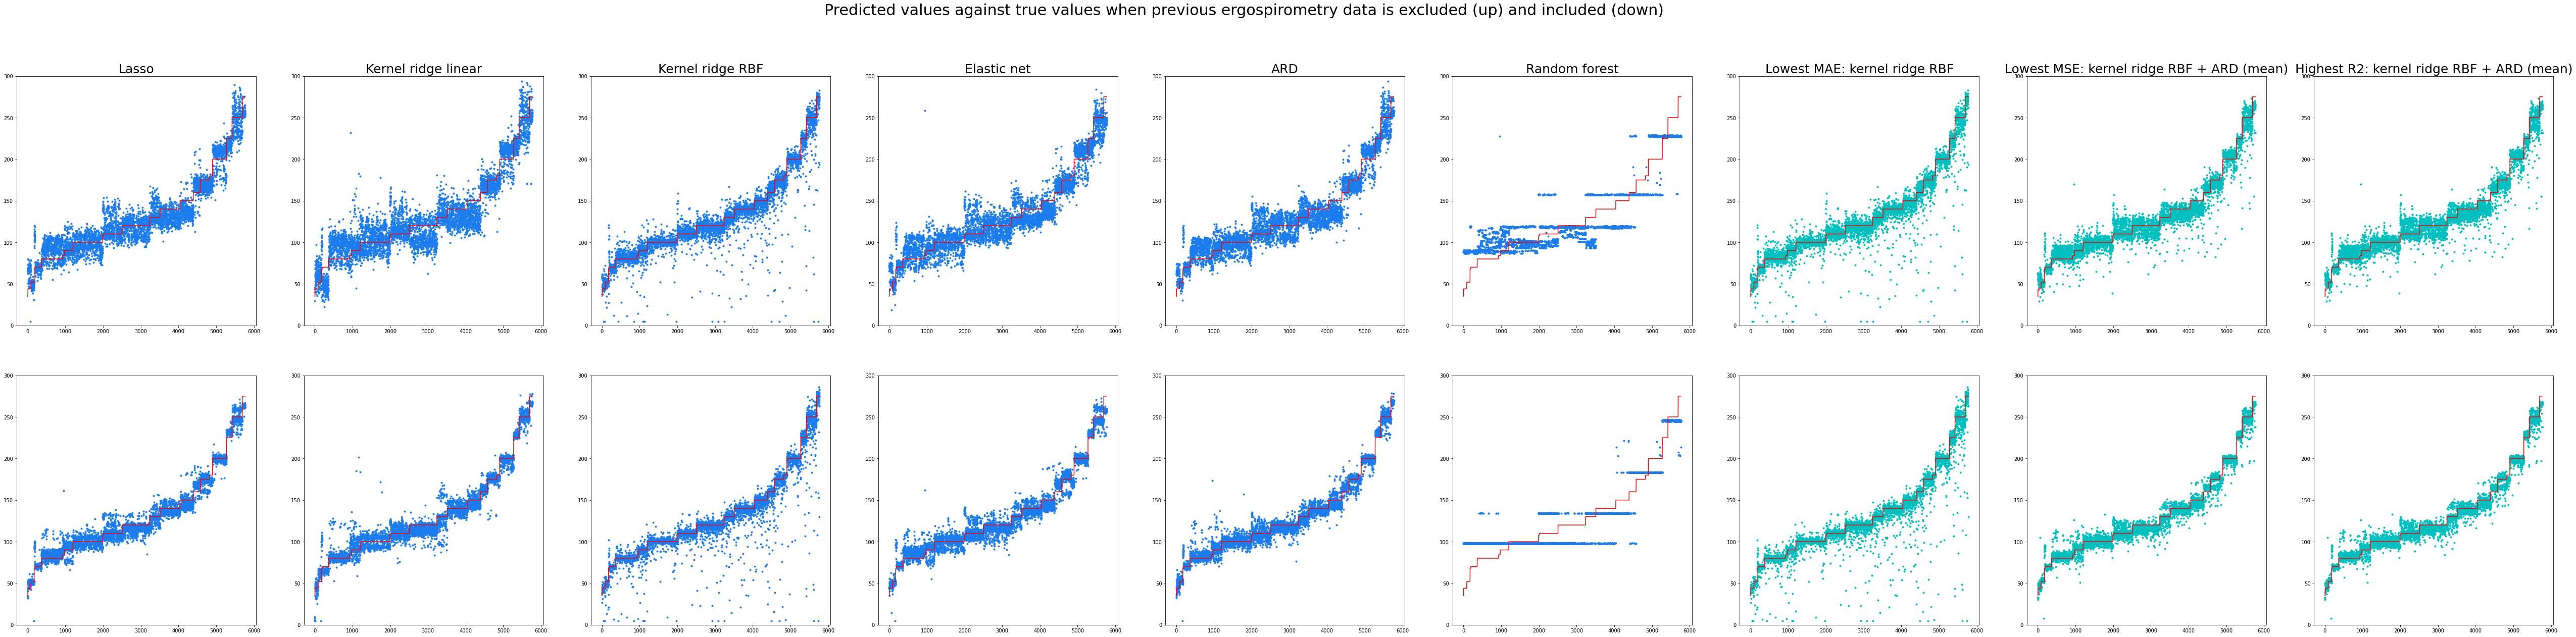

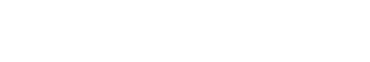

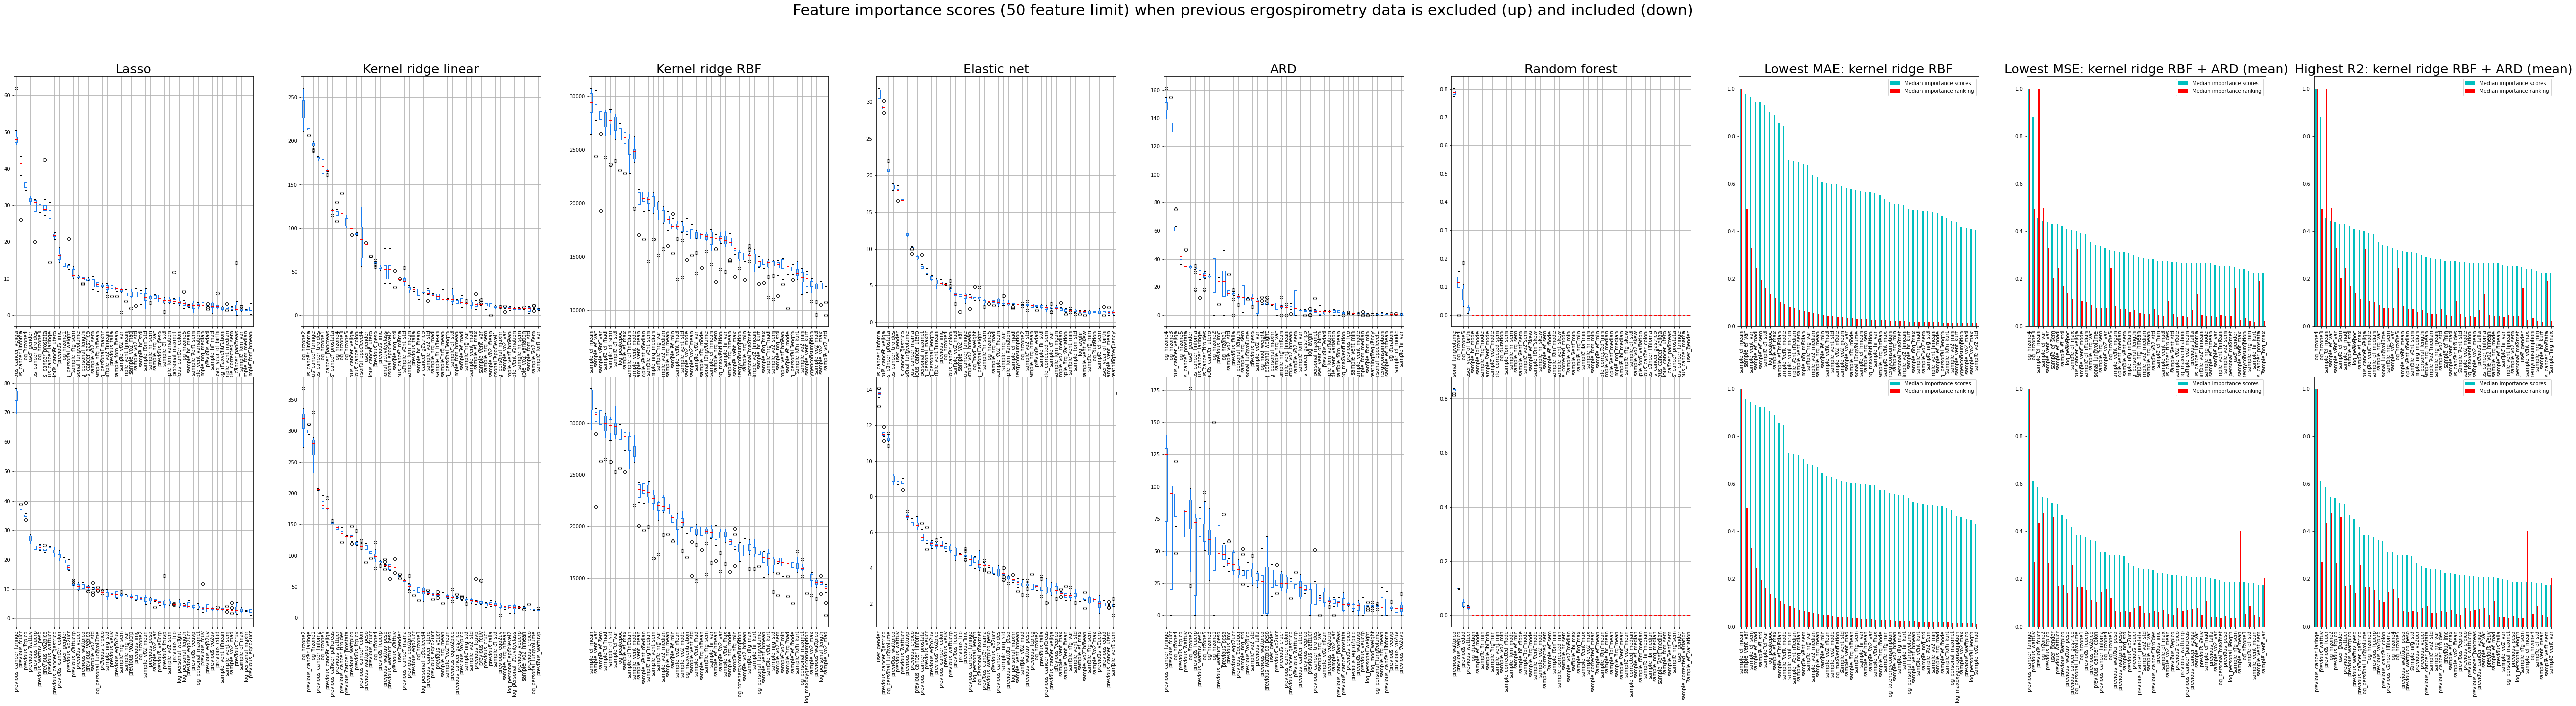

In [20]:
models = ['lasso', 'kernel-ridge-linear', 'kernel-ridge-rbf', 'elastic-net', 'ard', 'random-forest']
target = 'wattpico'
model_parameters = {'model': models, 'target': [target], 'previous': [False, True], 'cv': [10]}
user_index = data['user_id'].to_dict()
score_model(data_converted, model_parameters, user_index)

Regression results for fcuvp (10 cross-validation folds)
Models scored: lasso, kernel ridge linear, kernel ridge RBF, elastic net, ARD, random forest
Previous ergospirometry data excluded
Stand-alone models
Model                MAE        MSE        R2        
lasso                1.5866     13.0995    0.7437    
kernel ridge linear  2.6163     33.2435    0.352     
kernel ridge RBF     0.9961     28.4267    0.4449    
elastic net          1.8131     14.6729    0.7132    
ARD                  1.6355     12.652     0.7526    
random forest        2.6619     23.7721    0.5362    

Ensemble models
                                                                                 Aggregated by mean               Aggregated by median
Ensemble                                                                         MAE        MSE        R2         MAE        MSE        R2        
lasso + kernel ridge linear                                                      1.8921     17.2039    0.6647     1.

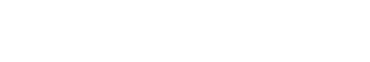

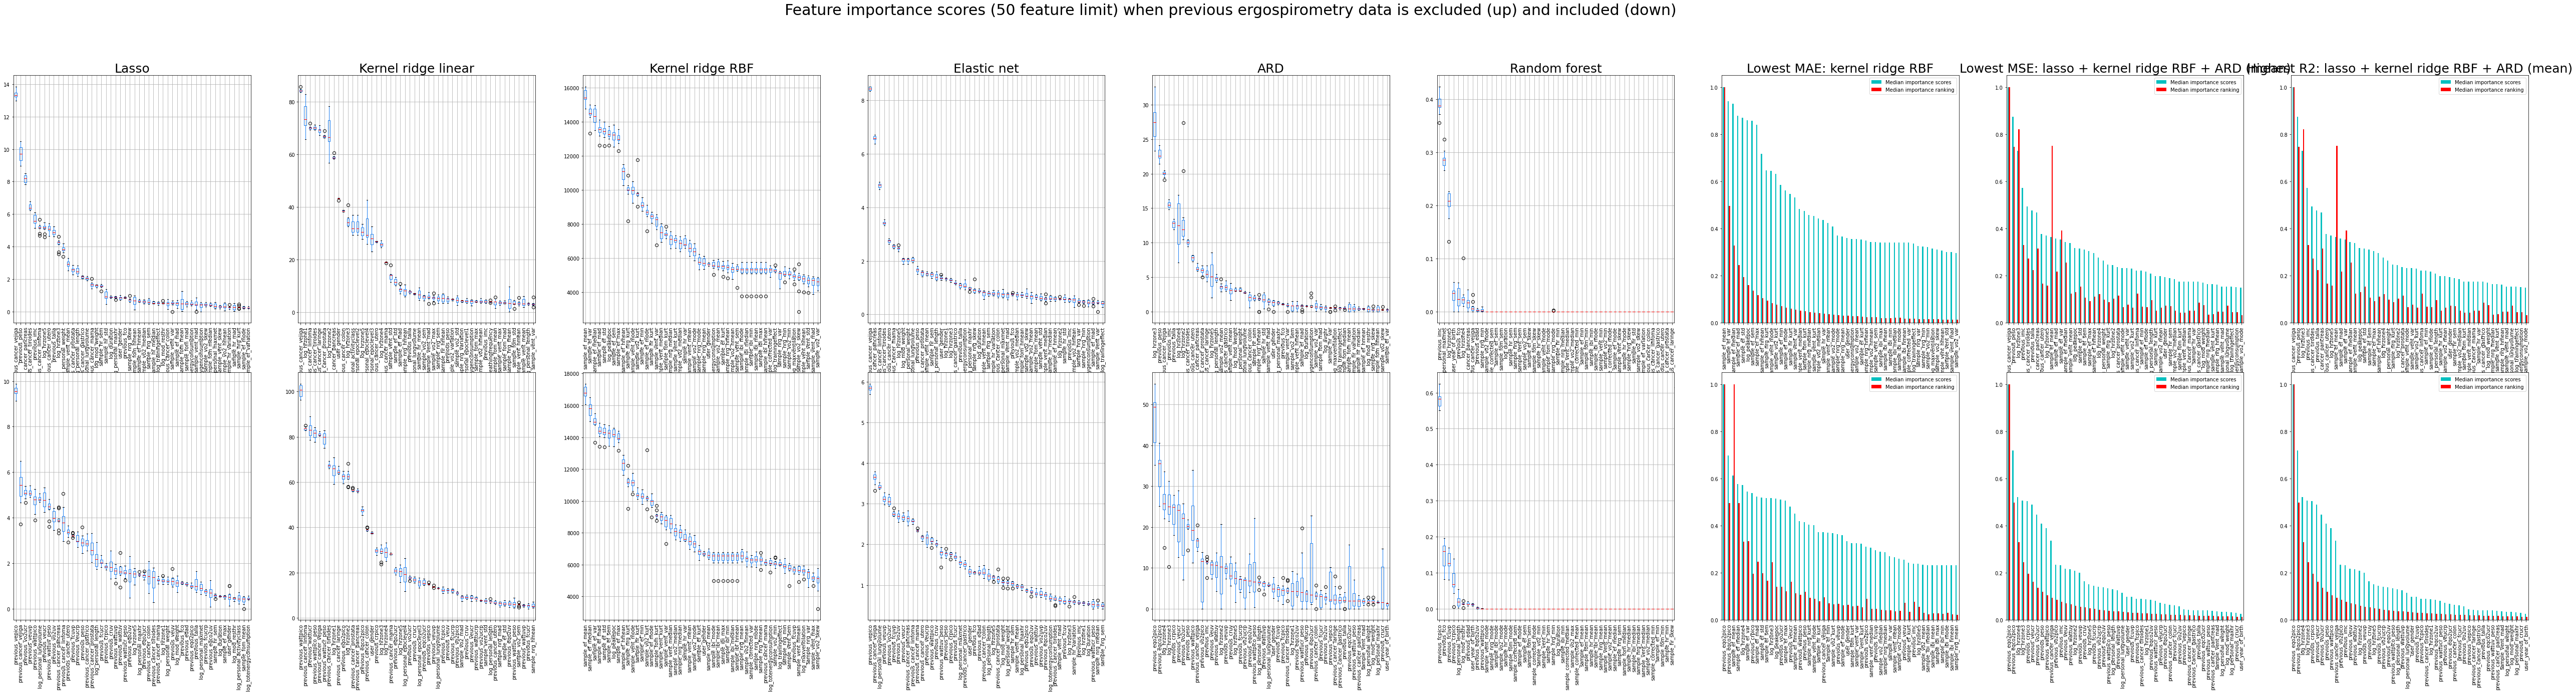

In [25]:
models = ['lasso', 'kernel-ridge-linear', 'kernel-ridge-rbf', 'elastic-net', 'ard', 'random-forest']
target = 'fcuvp'
model_parameters = {'model': models, 'target': [target], 'previous': [False, True], 'cv': [10]}
user_index = data['user_id'].to_dict()
score_model(data_converted, model_parameters, user_index)